# Analysis of LM Perplexities

## Imports and data loading

In [1]:
%matplotlib widget
import numpy as np, os, sys, matplotlib.pyplot as plt, seaborn as sns, pandas, orjson
from tqdm import tqdm
from iso639 import languages

In [2]:
def get_xy(np_array):
  return np.where(~np.isnan(np_array))[0], np_array[~np.isnan(np_array)]

In [3]:
def get_dict_of_arrays(exp_model_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='pppl.npy',convert_for_plot=True):
    np_arrays = {}
    
    for exp, models in exp_model_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            if convert_for_plot:
                np_arrays[model] = get_xy(np.load(file_name))
            else:
                np_arrays[model] = np.load(file_name)

    return np_arrays

In [4]:
def get_dict_of_df(df_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='filtered_df.csv'):
    
    dfs = {}
    
    for exp, models in df_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            dfs[model] = pandas.read_csv(file_name)
    return dfs

#### Define the models we're interested in working with using a dictionary of experiment_name:model_name pairs, and load the data

In [19]:
models = {
       'every_5_5000' : ['allenai/scibert_scivocab_cased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-cased']
}

# models = {
#     'every_5_5000' : ['roberta-base', 'xlm-roberta-base']
# }

In [20]:
dfs = get_dict_of_df(models, fname_to_read='filtered_df_with_moses_tokens.tsv')
pppl_arrays = get_dict_of_arrays(models) # PPPL already calculated with subwords
np_arrays = get_dict_of_arrays(models, fname_to_read='filtered_log_probs.npy', convert_for_plot=False) #Load the raw data to re-do calculations

print(f'{np_arrays[next(iter(dfs))].shape}\t(bin x sample_size x max_seq_len)')

(100, 5000, 128)	(bin x sample_size x max_seq_len)


In [25]:
# Cleanup some of the columns from the df
for model, df in dfs.items():
    dfs[model] = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
    df['num_unk'] = df['abstract_input'].apply(lambda x : x.count('[UNK]'))
    dfs[model] = df

    print(f'Model: {model:40s}\tNum Rows: {len(df):10d}')
    
# test_df = dfs['allenai/scibert_scivocab_cased']
# test_df[test_df['langdetect'] == 'zh-cn']

Model: allenai/scibert_scivocab_cased          	Num Rows:      97413
Model: bert-base-cased                         	Num Rows:      98168
Model: bert-large-cased                        	Num Rows:      98168
Model: bert-base-multilingual-cased            	Num Rows:      98041


Theres a difference in the number of rows because we filter out based on subwords and padding tokens, which is different for each abstract depending on the model

## Plotting Perplexities

### Perplexity normalized by subword

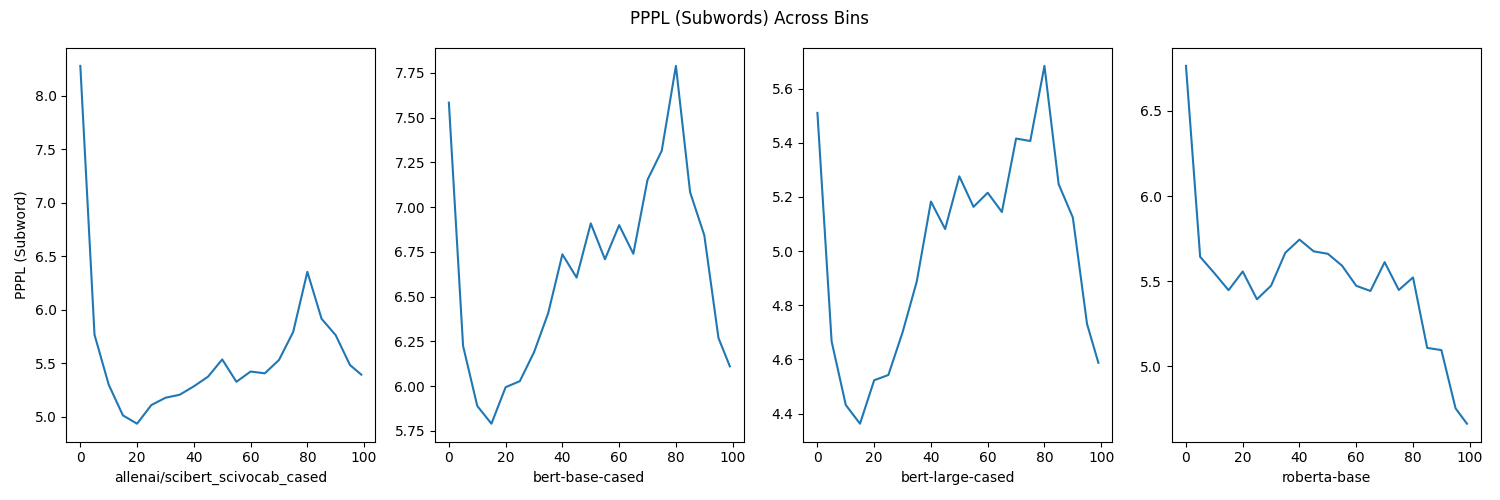

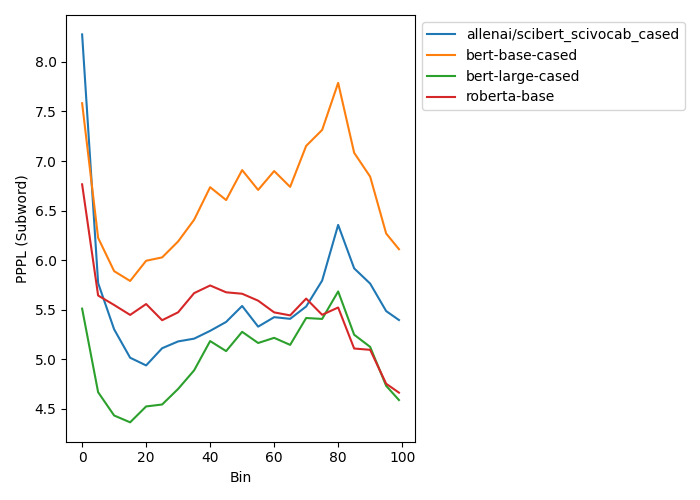

In [15]:

num_models = len(dfs)

ip_f, ip_a = plt.subplots(1, num_models, figsize=(15,5))
ipa_f, ipa_a = plt.subplots(figsize=(7,5))

for i, (model, array) in enumerate(pppl_arrays.items()):
    ip_a[i].plot(array[0], array[1])
    ip_a[i].set_xlabel(model)
    ipa_a.plot(array[0], array[1], label=model)
    
ip_a[0].set_ylabel('PPPL (Subword)')
ip_f.suptitle('PPPL (Subwords) Across Bins')
ip_f.tight_layout()


ipa_a.legend(bbox_to_anchor=(1,1), loc='upper left')
ipa_a.set_xlabel('Bin')
ipa_a.set_ylabel('PPPL (Subword)')
ipa_f.tight_layout()



### Plot the PPPL using different normalization methods (Moses)

In [27]:
def calculate_pppl(arr, counts=None):
    """
        arr: numpy array of shape sample_size x max_seq len
        counts: numpy array of shape (sample_size,)
        
        returns: pppl normalized by counts across all samples
    """
    total_sum = np.nansum(arr) * -1
    
    if counts is not None:
        total_counts = np.nansum(counts)
    else:
        total_counts = np.sum(~np.isnan(arr))
    return np.exp(total_sum / total_counts)

In [28]:
def get_pppl_per_bin(df, arr, count_col=None):
    bins = df['bin'].unique()
    bins_pppl = np.zeros(bins.shape)

    for j, b in enumerate(bins):
        bin_counts = df[df['bin'] == b][count_col] if count_col else None
        np_indexer = df[df['bin'] == b]['local_id']

        bins_pppl[j] = calculate_pppl(arr[b][np_indexer], bin_counts)
        
    return bins, bins_pppl

In [287]:
for i, (model, df) in enumerate(dfs.items()):
    dfs[model]['num_chars'] = df['abstract_input'].apply(lambda x : len(x))
    dfs[model]['num_spaces'] = df['abstract_input'].apply(lambda x : x.count(' '))

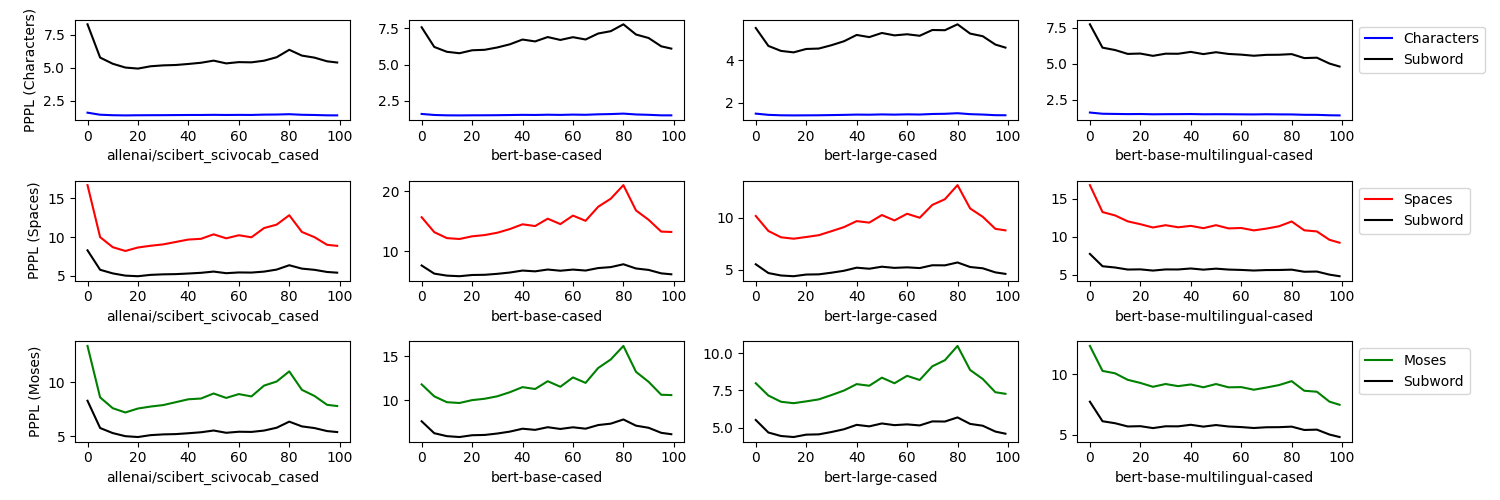

In [288]:
moses_f, moses_a = plt.subplots(3, num_models, figsize=(15,5))
colors = ['blue', 'red', 'green']

for k, (name, col) in enumerate(zip(['Characters', 'Spaces', 'Moses'],['num_chars', 'num_spaces', 'num_moses_tokens'])):
    for i, (model, df) in enumerate(dfs.items()):
        
        bins, bins_pppl = get_pppl_per_bin(df, np_arrays[model], col)
        moses_a[k][i].plot(bins, bins_pppl, color=colors[k], label=name)
        moses_a[k][i].plot(pppl_arrays[model][0], pppl_arrays[model][1], color='black', label='Subword')

        moses_a[k][i].set_xlabel(model)
    
    moses_a[k][0].set_ylabel(f'PPPL ({name})')

    moses_a[k][-1].legend(bbox_to_anchor=(1,1), loc='upper left')
    
moses_f.tight_layout()

## Stratifying by Source Domain

Theres a lot of changes in perplexity across bins -- how much of this is due to the language of the abstracts versus qualities of the data from the bin (i.e. is our language usage changing or does one bin just have a lot of erroneous abstracts?)

Lets focus on SciBERT first.

In [290]:
model = 'allenai/scibert_scivocab_cased'

df = dfs[model]

sources = [col for col in df.columns if 'has_' in col]
print('Columns which denote sources:')
print(sources)


Columns which denote sources:
['has_mag', 'has_acl', 'has_doi', 'has_pubmedcentral', 'has_arxiv', 'has_pubmed']


#### Leave one source out

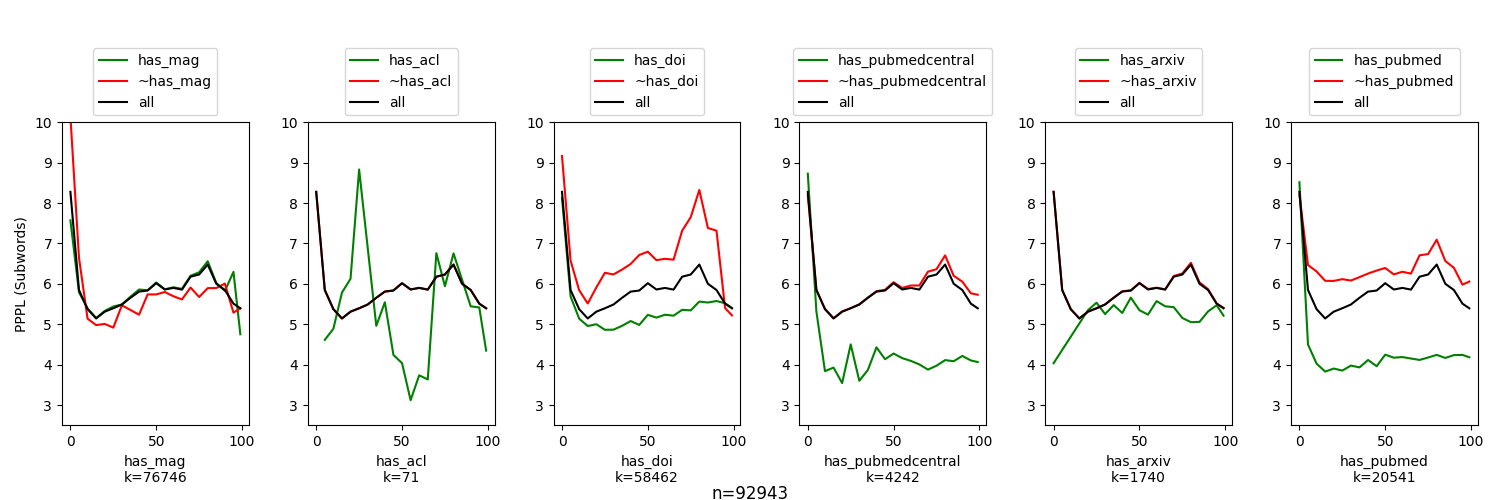

In [291]:
loo_f, loo_a = plt.subplots(1,len(sources), figsize=(15,5))

colors = ['green', 'red', 'black']
for i, source in enumerate(sources):
    
    source_df = df[df[source] == True]
    non_source_df = df[df[source] == False]
    
    
    for j, (d, name) in enumerate(zip([source_df, non_source_df, df], [source, '~' + source, 'all'])):
        bins, bins_pppl = get_pppl_per_bin(d, np_arrays[model])
        loo_a[i].plot(bins, bins_pppl, label=name, color=colors[j])
        loo_a[i].set_xlabel(source + f'\nk={len(source_df)}')
        loo_a[i].set_ylim(bottom=2.5, top=10)
        loo_a[i].legend(bbox_to_anchor=(0.5,1), loc='lower center')
        
loo_a[0].set_ylabel('PPPL (Subwords)')
loo_f.suptitle(f'n={len(df)}', y=0.03)
loo_f.tight_layout()

#### Sample of papers not from pubmed or not with DOI

If a paper doesn't have a DOI or is not from pubmed, then it is very difficult for the model. What do these papers look like?

In [16]:
pandas.set_option('display.max_colwidth', 150)
df[df['has_doi'] == False][['abstract_input', 'langdetect']].sample(n=30, random_state=43)

,abstract_input,langdetect
42600,guidance differentiation cultivates in 6 - ba and zt. ch are qualified for according to certain thickness than being put into use. bud's different...,en
31856,"for small internal measurement requirement, effects of some parameter in the system, such as the detector pinhole size, the detector position, the...",en
43597,"based on simo, modal experiment is carried out analyze dynamic characteristics on frame, bottom - board and joint parts of certain type military t...",en
47920,"in this study, the role of acetylsalicylic acid ( asa ) pre - treatment ( 1 or 10 μm ) in inducing salt and osmotic tolerance was investigated in ...",en
57450,"among the possibilities that education allows to investigate, this paper aims to discuss the aspects related to distant education. it focuses on t...",en
67178,objective to observe the effect of formaldehyde inhalation on the allergic rhinitis mice model. method forty - eight male balb / c mice in six exp...,en
25482,"[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK], [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] ; [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]...",ko
27476,"in his “ regional ” novel, passage of the poet, in a stable setting but changing times ramuz tells us about the habitants of the vaud region and t...",en
45408,"• if only sea salt aerosol production from open sea water is considered, in winter the value should be much lower than in summer because of the la...",en
27415,lichen amyloidosis is a chronic intensely pruritic skin disorder characterized histologi - cally by the deposition of amyloid in the papillary der...,en


In [17]:
df[df['has_pubmed'] == False][['abstract_input', 'langdetect']].sample(n=30, random_state=43)

,abstract_input,langdetect
81407,organic chemistry concurrent operation of two or more catalytic cycles requires a delicate balance of relative rates. zhang et al. developed an am...,en
40407,"the scalar and tensor ( dyadic ) green's functions ( gfs ) for three - dimensional - periodic ( 3dp ), two - dimensional - periodic ( 2dp ) and on...",en
36757,we proposed a model that included individual and situational antecedents of self - efficacy development during training. initial performance and s...,en
82039,113 background : the prevalence of esophageal stenosis caused by ici in the context of induced immune mucositis and esophagitis is extremely rare....,en
12038,nobody can deny that phoniatric examinations including aenodynamics analyzing vibratory patterns of the vocal folds'or the like may play a very im...,en
93634,"climate change has had several negative effects, including more severe storms, warmer oceans, high temperatures and, in particular, increased drou...",en
81413,"this work presents two capacitor mismatch error reduction techniques, sorted - capacitor averaging ( sca ) and two - phase averaging ( tpa ), comb...",en
8448,"a very slow change in the dc conductivity below 200°c of certain alkali halide single crystals, not previously investigated, cannot be understood ...",en
93218,"purposeaccording to the government response tracker ( oxcgrt ) index, the strictest policy responses to the coronavirus pandemic from january 2020...",en
78863,this paper introduces a design approach for rotary travelling - wave oscillator ( rtwo ) circuit utilizing lumped phase shift networks to enable c...,en


Lets look at non-DOI papers from bin 80 (the peak of perplexity)

In [18]:
df[(df['has_doi'] == False) & (df['bin'] == 80)][['abstract_input', 'langdetect']].sample(n=30, random_state=43)

,abstract_input,langdetect
74126,penelitian ini bertujuan untuk menganalisis pertimbangan hakim dalam menjatuhkan putusan lepas dari segala tuntutan hukum terhadap terdakwa kalimi...,id
74605,"in 2010, 1, 500 chief executive officers identified managers'creativity as the most crucial factor for future organizational success. however, man...",en
76148,"the aim of this study is to simulate flow over two types of generic vehicle model. the simulation is done using the open source cfd solver, openfo...",en
74765,the women ’ s xxth century philosophical reflections on the disumanization of history clearly still show their relevance for our present. starting...,en
77905,wind power forecasting trials and benchmarking have become more and more popular over the past few years. numerous similar benchmarking and trials...,en
76505,austenitic stainless steel 316l ( n ) and alloy 800 are potential candidates for structural components of generation iv nuclear reactors. their in...,en
78160,"stem career opportunities are plentiful worldwide ; however, students are not always able to find those opportunities due to location, time constr...",en
78214,"vilnius, lapkricio 20 d. ( bns ) — tevynes sajungos ( lietuvos konservatoriu ) ir krikscioniu demokratu partijos vadovai treciadieni pasirase koal...",lt
77780,"trata - se de uma carta de propositos, submetida ao exame do colegio das artes da universidade de coimbra ( portugal ), no ambito da selecao publi...",pt
76833,"background and aim : according to the guidelines approved by international scientific associations, the assessment of the vestibular system and it...",en


## Stratifying by language

#### Number of languages per bin

Text(0, 0.5, 'Proportion of English in Sample')

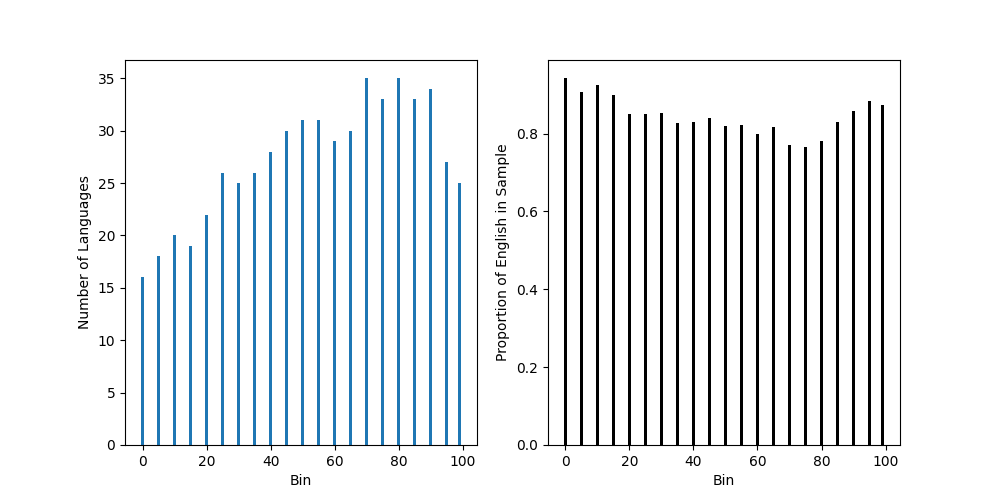

In [16]:
bins = df['bin'].unique()
lang_counts = np.zeros(bins.shape)
english_proportion = np.zeros(bins.shape)

nlf, nla = plt.subplots(1,2, figsize=(10,5))

for i, bidx in enumerate(bins):
    bdf = df[df['bin'] == bidx]
    lang_counts[i] = len(bdf['langdetect'].unique())
    english_proportion[i] = len(bdf[bdf['langdetect'] == 'en']) / len(bdf)
    
nla[0].bar(bins, lang_counts, width=1)
nla[1].bar(bins, english_proportion, width=1, color='black')
nla[0].set_xlabel('Bin')
nla[0].set_ylabel('Number of Languages')
nla[1].set_xlabel('Bin')
nla[1].set_ylabel('Proportion of English in Sample')

The number of non-english papers is increasing, but the proportion of english papers doesn't dip below ~77%. 
Note that bin 80 has the largest number of non-english languages and the lowest proprtion of English.

What are the other languages?

In [293]:
t = df['langdetect'].value_counts()
pandas.concat([t.index.to_series().apply(lambda x : languages.get(alpha2=x[:2]).name).rename('Name'), t.rename('Count')], axis=1).reset_index()

,index,Name,Count
0,en,English,82308
1,fr,French,2510
2,es,Spanish,2033
3,id,Indonesian,1787
4,pt,Portuguese,1569
5,de,German,1146
6,tr,Turkish,319
7,sv,Swedish,173
8,cs,Czech,169
9,it,Italian,138


#### Proprtion of languages over time
How does the proprtion of languages change over time?

In [27]:
len(df)

97413

In [21]:
df[df['langdetect'] == 'id']['bin'].value_counts()

80    255
85    226
75    195
90    160
70    153
95    151
99    133
65     91
60     89
50     68
55     66
45     56
40     41
35     34
25     20
30     15
0      15
5       8
20      6
15      4
10      1
Name: bin, dtype: int64

Lets look at SciBERT and mBERT performance on English vs Non-english abstracts

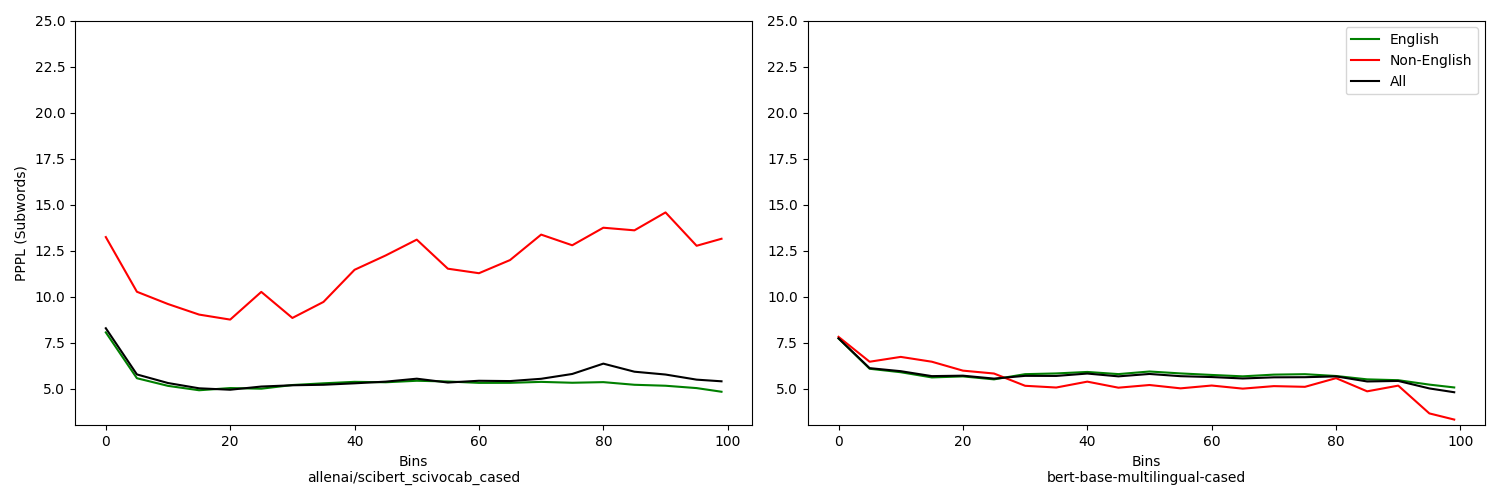

In [30]:
enef, enea = plt.subplots(1,2, figsize=(15,5))
colors = ['green', 'red', 'black']
for i, model in enumerate(['allenai/scibert_scivocab_cased', 'bert-base-multilingual-cased']):
    
    all_df = dfs[model]
    english_df = all_df[all_df['langdetect'] == 'en']
    non_english_df = all_df[(all_df['langdetect'] != 'en') & (all_df['num_unk'] < 10)]
    
    for j, (d, name) in enumerate(zip([english_df, non_english_df, all_df], ['English', 'Non-English', 'All'])):
        bins, bins_pppl = get_pppl_per_bin(d, np_arrays[model])
        enea[i].plot(bins, bins_pppl, color=colors[j], label=name)
        enea[i].set_xlabel(f'Bins\n{model}')
        enea[i].set_ylim(top=25, bottom=3)
        
enea[0].set_ylabel('PPPL (Subwords)')
enea[1].legend()
enef.tight_layout()

## Stratifying by both language and domain

#### Pubmed and DOI

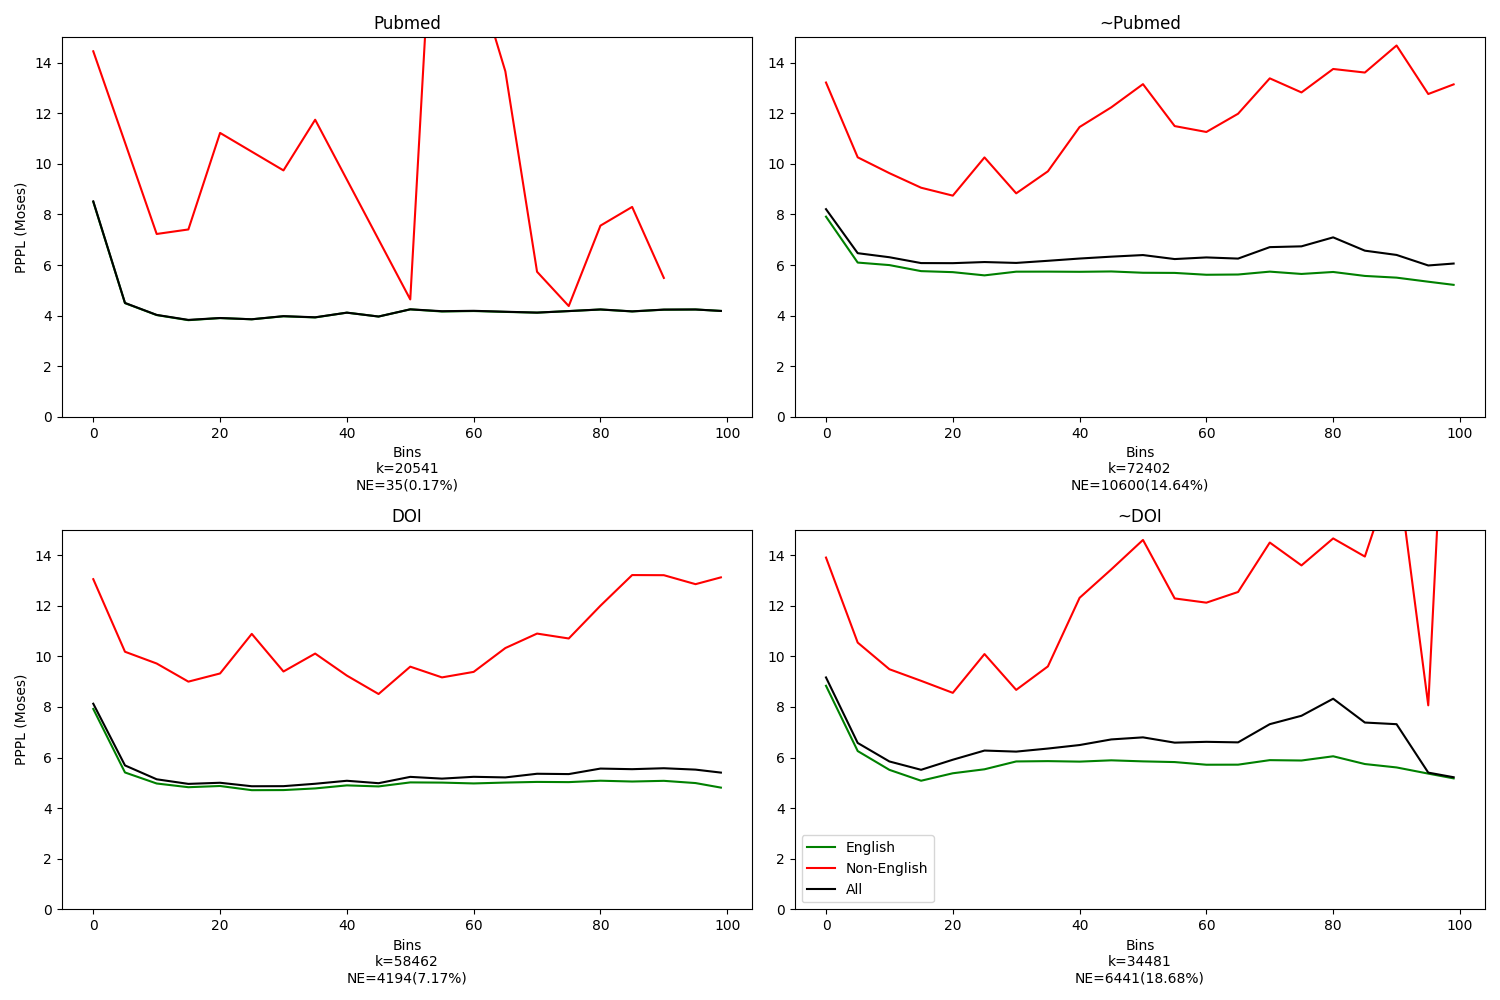

In [295]:
domains = ['has_pubmed', 'has_doi']
names = ['Pubmed', 'DOI']
colors = ['green', 'red', 'black']
model = 'allenai/scibert_scivocab_cased'
dlf, dla = plt.subplots(len(domains), 2, figsize=(15,10))

for domain_idx, (domain, name) in enumerate(zip(domains,names)):
    
    for in_domain_idx, truth_val in enumerate([True, False]):
    
        all_df = dfs['allenai/scibert_scivocab_cased']
        all_df = all_df[all_df[domain] == truth_val]
        english_df = all_df[all_df['langdetect'] == 'en']
        non_english_df = all_df[(all_df['langdetect'] != 'en') & (all_df['langdetect'] != 'zh-cn')]

        for j, (d, lang_name) in enumerate(zip([english_df, non_english_df, all_df], ['English', 'Non-English', 'All'])):
            bins, bins_pppl = get_pppl_per_bin(d, np_arrays[model])
            dla[domain_idx][in_domain_idx].plot(bins, bins_pppl, color=colors[j], label=lang_name)
            dla[domain_idx][in_domain_idx].set_xlabel(f'Bins\nk={len(all_df)}\nNE={len(non_english_df)}({100*len(non_english_df)/len(all_df):2.2f}%)')
            dla[domain_idx][in_domain_idx].set_ylim(top=15, bottom=0)
            
        notstring = '' if truth_val else '~'
        dla[domain_idx][in_domain_idx].set_title(notstring + name)
        
dla[0][0].set_ylabel('PPPL (Moses)')
dla[1][0].set_ylabel('PPPL (Moses)')

dla[1][1].legend()



dlf.tight_layout()

## Perplexity on only 'clean' abstracts

Text(0.5, 0.03, 'Bin')

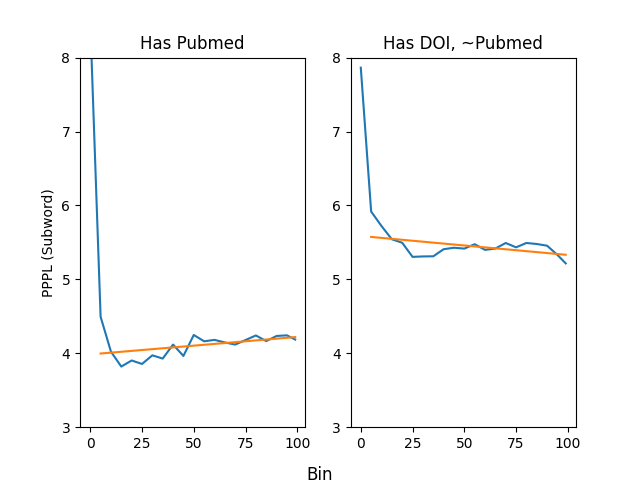

In [253]:
clean_df = dfs['allenai/scibert_scivocab_cased']
domains = ['has_pubmed', 'has_doi']
names = ['Pubmed', 'DOI']
cleanf, cleana = plt.subplots(1,len(domains))

for domain_idx, (domain, name) in enumerate(zip(domains, names)):
    clean_df = dfs['allenai/scibert_scivocab_cased']
    clean_df = clean_df[(clean_df['langdetect'] == 'en') & (clean_df[domain] == True)]
    
    if domain == 'has_doi':
        clean_df = clean_df[clean_df['has_pubmed'] != True]

    bins, bins_pppl = get_pppl_per_bin(clean_df, np_arrays['allenai/scibert_scivocab_cased'])
    


    cleana[domain_idx].plot(bins, bins_pppl, label=name)
    cleana[domain_idx].plot(np.unique(bins[1:]), np.poly1d(np.polyfit(bins[1:], bins_pppl[1:], 1))(np.unique(bins[1:])))
    cleana[domain_idx].set_ylim(bottom=3, top=8)

cleana[0].set_title('Has Pubmed')
cleana[0].set_ylabel('PPPL (Subword)')
cleana[1].set_title('Has DOI, ~Pubmed')
cleanf.suptitle('Bin', y=0.03)

Text(0.5, 0.03, 'Bin')

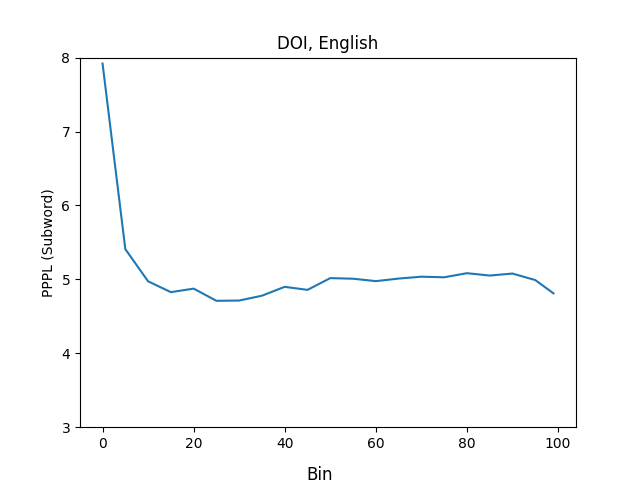

In [304]:
scleanf, scleana = plt.subplots()


clean_df = dfs['allenai/scibert_scivocab_cased']
clean_df = clean_df[(clean_df['has_doi'] == True) & (clean_df['num_unk'] < 10) & (clean_df['langdetect'] == 'en')]
bins, bins_pppl = get_pppl_per_bin(clean_df, np_arrays['allenai/scibert_scivocab_cased'])

scleana.plot(bins, bins_pppl, label=name)
# scleana.plot(np.unique(bins[1:]), np.poly1d(np.polyfit(bins[1:], bins_pppl[1:], 1))(np.unique(bins[1:])))
scleana.set_ylim(bottom=3, top=8)

scleana.set_title('DOI, English')
scleana.set_ylabel('PPPL (Subword)')
scleanf.suptitle('Bin', y=0.03)

We still see this time structure. We can check the standard deviations to see if the differences are actually real

#### Perplexity with standard deviations

In [78]:
def calculate_std(arr, counts=None):
    """
        arr: numpy array of shape sample_size x max_seq len
        counts: numpy array of shape (sample_size,)
        
        returns: std normalized by subword (n = subwords)
    """
    return np.nanstd(arr)
    

def get_pppl_std_per_bin(df, arr, count_col=None):
    bins = df['bin'].unique()
    bins_pppl = np.zeros(bins.shape)
    stds = np.zeros(bins.shape)
    counts = np.zeros(bins.shape)

    for j, b in enumerate(bins):
        bin_counts = df[df['bin'] == b][count_col] if count_col else None
        np_indexer = df[df['bin'] == b]['local_id']

        bins_pppl[j] = calculate_pppl(arr[b][np_indexer], bin_counts)
        stds[j] = calculate_std(arr[b][np_indexer], bin_counts)
        counts[j] = np.sum(~np.isnan(arr[b][np_indexer]))
        
    return bins, np.log(bins_pppl, stds, counts

[11.37288023  5.01651877  4.42943897  4.21313297  4.32207005  4.21785053
  4.35948342  4.26632959  4.47640477  4.30022355  4.7263033   4.56943313
  4.55905266  4.53037314  4.45133233  4.60482312  4.61304576  4.51078995
  4.56739391  4.59365881  4.49765952]
[18.71259531  2.84643113  2.20854574  2.25622037  2.27096551  2.05743004
  2.15887502  1.95934976  2.0549716   1.91988296  2.65366179  2.25651974
  2.10236352  2.16823943  1.94620648  2.45313118  2.09572024  2.0525503
  1.97510453  2.09476803  1.87700829]


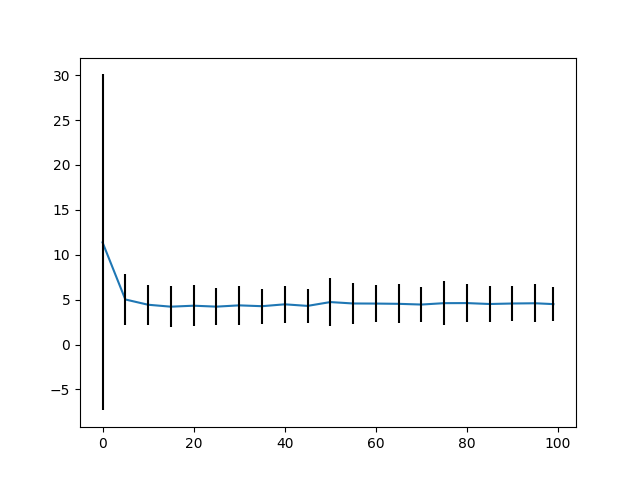

In [222]:
def calculate_std(arr, counts=None):
    """
        arr: numpy array of shape sample_size x max_seq len
        counts: numpy array of shape (sample_size,)
        
        returns: std normalized by subword (n = subwords)
    """
    return np.nanstd(arr)
    

def get_pppl_std_per_bin(df, arr, count_col=None):
    bins = df['bin'].unique()
    bin_sentence_mean = np.zeros(bins.shape)
    bin_sentence_std = np.zeros(bins.shape)
    counts = np.zeros(bins.shape)
    sentence_scores = []

    for j, b in enumerate(bins):
        np_indexer = df[df['bin'] == b]['local_id']

        sentence_sums = np.nansum(arr[b][np_indexer], axis=1)
        sentence_counts = np.nansum(~np.isnan(arr[b][np_indexer]), axis=1)
        
        per_sentence_scores = np.exp(-1 * sentence_sums / sentence_counts)
        sentence_scores.append(per_sentence_scores)
        
        per_sentence_mean = np.mean(per_sentence_scores)
        per_sentence_std = np.std(per_sentence_scores)
        
        bin_sentence_mean[j] = per_sentence_mean
        bin_sentence_std[j] = per_sentence_std
        counts[j] = per_sentence_scores.shape[0]
        
    return bins, sentence_scores, bin_sentence_mean, bin_sentence_std, counts




clean_df = dfs['allenai/scibert_scivocab_cased']
clean_df = clean_df[(clean_df['langdetect'] == 'en') & (clean_df['has_pubmed'] == True)]

bins, sentence_scores, means, stds, counts = get_pppl_std_per_bin(clean_df, np_arrays['allenai/scibert_scivocab_cased'])
cleanstdf, cleanstda = plt.subplots()
cleanstda.plot(bins, means)
# cleanstda.scatter(bins, means + stds)
# cleanstda.scatter(bins, means - stds)
cleanstda.vlines(x=bins, ymin=means-stds, ymax=means+stds, color='black')

print(means)
print(stds)

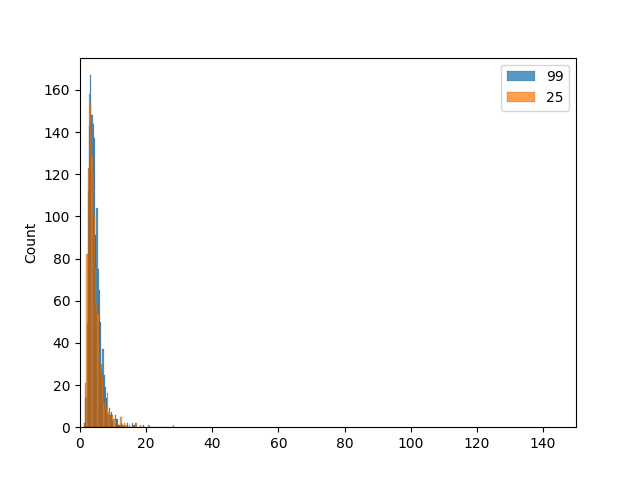

In [223]:
histf, hista = plt.subplots()
hista.set_xlim(right=150)
sns.histplot(sentence_scores[20], ax=hista, label=f'{bins[20]}')
sns.histplot(sentence_scores[4], ax=hista, label=f'{bins[5]}')
hista.legend()


In [265]:
d = dfs['allenai/scibert_scivocab_cased']
a = np_arrays['allenai/scibert_scivocab_cased']
d = d[d['bin'] == 20]
d = d[(d['langdetect'] == 'en') & (clean_df['has_pubmed'] == False)]
d

/rc_scratch/abeb4417/abeb4417/tmp/ipykernel_2581/286603532.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d = d[(d['langdetect'] == 'en') & (clean_df['has_pubmed'] == False)]


,bin,local_id,corpusid,abstract,tokens,num_unique_tokens,num_total_tokens,num_unk_tokens,langdetect,has_mag,has_acl,has_doi,has_pubmedcentral,has_arxiv,has_pubmed,abstract_input,num_moses_tokens
